In [1]:
%cd ../script

/Users/andrejerkelens/Desktop/GPCE/gpce-covid/v0/script


In [2]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
import tensorflow as tf
import os, gc, json
import pandas as pd
from pandas import to_datetime
from utils import train_validation_test_split
import argparse
from utils import scale_back, calculate_result, sumCases

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

import sys
sys.path.append( '..' )
from Class.Trainer import Trainer
from Class.ParameterManager import ParameterManager
from Class.DataProcessor import DataProcessor
from Class.Plotter import PlotResults, PlotWeights

In [4]:
checkpoint_folder = '../output/checkpoints'

In [5]:
figure_folder = os.path.join('../output','figures')

In [6]:
if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder, exist_ok=True)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder, exist_ok=True)

In [7]:
print(f'Loading config.json from ../config_2022_May.json')
with open('../config_2022_May.json') as inputfile:
    config = json.load(inputfile)
    inputfile.close()

Loading config.json from ../config_2022_May.json


In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
dataPath = '../2022_May/Population_cut.csv'

In [10]:
print(f'Loading input data from {dataPath}')
df = pd.read_csv(dataPath)
print(f'Input feature file shape {df.shape}')

Loading input data from ../2022_May/Population_cut.csv
Input feature file shape (81000, 21)


In [11]:
df['Date'] = to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

In [12]:
parameterManager = ParameterManager(config)

In [13]:
df.columns

Index(['FIPS', 'AgeDist', 'AirPollution', 'HealthDisp', 'Name', 'Date',
       'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist',
       'Cases', 'Deaths', 'TimeFromStart', 'LinearSpace', 'Constant',
       'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'],
      dtype='object')

In [14]:
print(f'Column mappings: {parameterManager.col_mappings}\n')

"""# Train validation split and Scaling"""
train_data, validation_data, test_data, target_scaler = train_validation_test_split(df, parameterManager, scale=True)
print(f'Number train data is {train_data.shape[0]}, validation {validation_data.shape[0]}, test {test_data.shape[0]}')

gc.collect()

Column mappings: {'Static': ['AgeDist', 'AirPollution', 'HealthDisp'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases', 'Deaths'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']}

Number train data is 64000, validation 8200, test 8800


0

In [15]:
trainer = Trainer(parameterManager)
model = trainer.create_model()

optimizer_params = parameterManager.optimizer_params
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm']
)

Metal device set to: Apple M1 Pro


2022-07-20 22:11:53.185365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-20 22:11:53.185469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
checkpoint_folder

'../output/checkpoints'

In [17]:
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkpoint_folder, max_to_keep=1)

model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
if model is None:
    sys.exit(-1)

Checkpoint restored from ../output/checkpoints/ckpt-9


In [18]:
dataProcessor = DataProcessor(
    parameterManager.total_sequence_length, parameterManager.col_mappings, parameterManager.data_params
)
"""### Train"""
train_batch = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = trainer.predict(model, train_batch)

train_actuals = scale_back(train_actuals, target_scaler, parameterManager.target_sequence_length)
train_preds = scale_back(train_preds, target_scaler, parameterManager.target_sequence_length)

train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds, split=True)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')
gc.collect()

2022-07-20 22:12:03.390667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-20 22:12:03.392988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:12:04.627967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:12:04.679520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:00.189606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:02.114762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:02.161631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

(64, 15, 2)
(52, 15, 2)
(64, 15, 2)
(52, 15, 2)
Train MAE [125.2306, 2.7044], RMSE [333.8729, 6.7028], SMAPE [0.6402, 1.2367]


0

In [19]:
"""### Validation"""
validation_batch = dataProcessor.prepare_batch(validation_data)
validation_preds, validation_actuals, _ = trainer.predict(model, validation_batch)

validation_preds = scale_back(validation_preds, target_scaler, parameterManager.target_sequence_length)
validation_actuals = scale_back(validation_actuals,  target_scaler, parameterManager.target_sequence_length)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds, split=True)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

2022-07-20 22:13:09.803772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:11.749026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:11.791495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 15, 2)
(60, 15, 2)
(64, 15, 2)
(60, 15, 2)
Validation MAE [618.1191, 5.3656], RMSE [1365.0364, 11.5308], SMAPE [1.2474, 1.3601]


In [20]:
"""### Test"""

test_batch = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, _ = trainer.predict(model, test_batch)

test_actuals = scale_back(test_actuals, target_scaler, parameterManager.target_sequence_length) 
test_preds = scale_back(test_preds, target_scaler, parameterManager.target_sequence_length)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds, split=True)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

#del model
gc.collect()

2022-07-20 22:13:19.034593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:21.681122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 22:13:21.725124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(64, 15, 2)
(20, 15, 2)
(64, 15, 2)
(20, 15, 2)
Test MAE [188.6396, 1.8068], RMSE [468.552, 5.0105], SMAPE [1.3101, 1.7065]


0

In [27]:
number_of_locations = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'Number of locations {number_of_locations}')
locs = df[parameterManager.col_mappings['ID']].iloc[:number_of_locations, 0].values

Number of locations 100


In [30]:
[str(target) for target in parameterManager.target_column]

['Cases', 'Deaths']

In [25]:
"""
Test prediction
"""
targets, predictions = sumCases(train_actuals,train_preds, number_of_locations)

PlotC = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder, parameterManager.target_column)
plot_titles = [f'Summed plot (Validation) MAE {mae:0.3f}, RMSE {rmse:0.3f}, SMAPE {smape:0.3f}' for mae,rmse,smape in zip(validation_mae, validation_rmse, validation_smape)]
figure_names = ['Summed validation: ' + str(target) for target in parameterManager.target_column]

61300 15 2


[Timestamp('2020-02-28 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-03 00:00:00'), Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-07 00:00:00'), Timestamp('2020-03-08 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-14 00:00:00'), Timestamp('2020-03-15 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('20

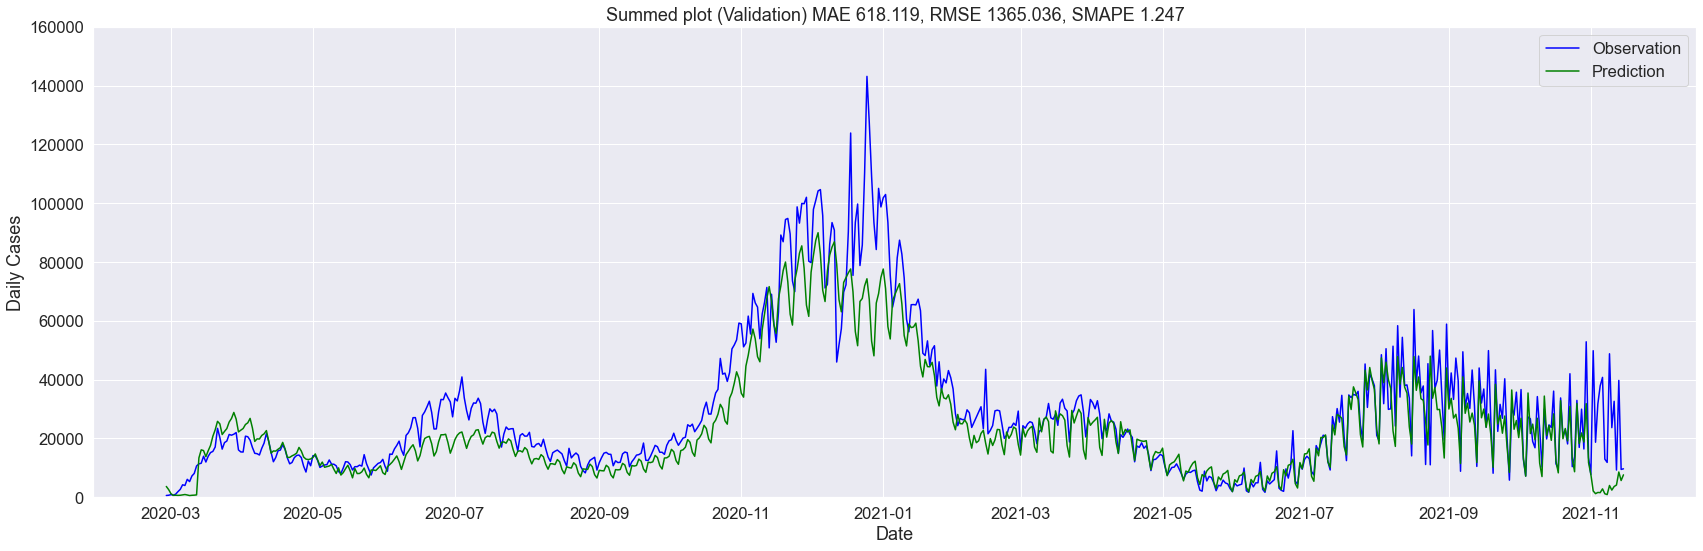

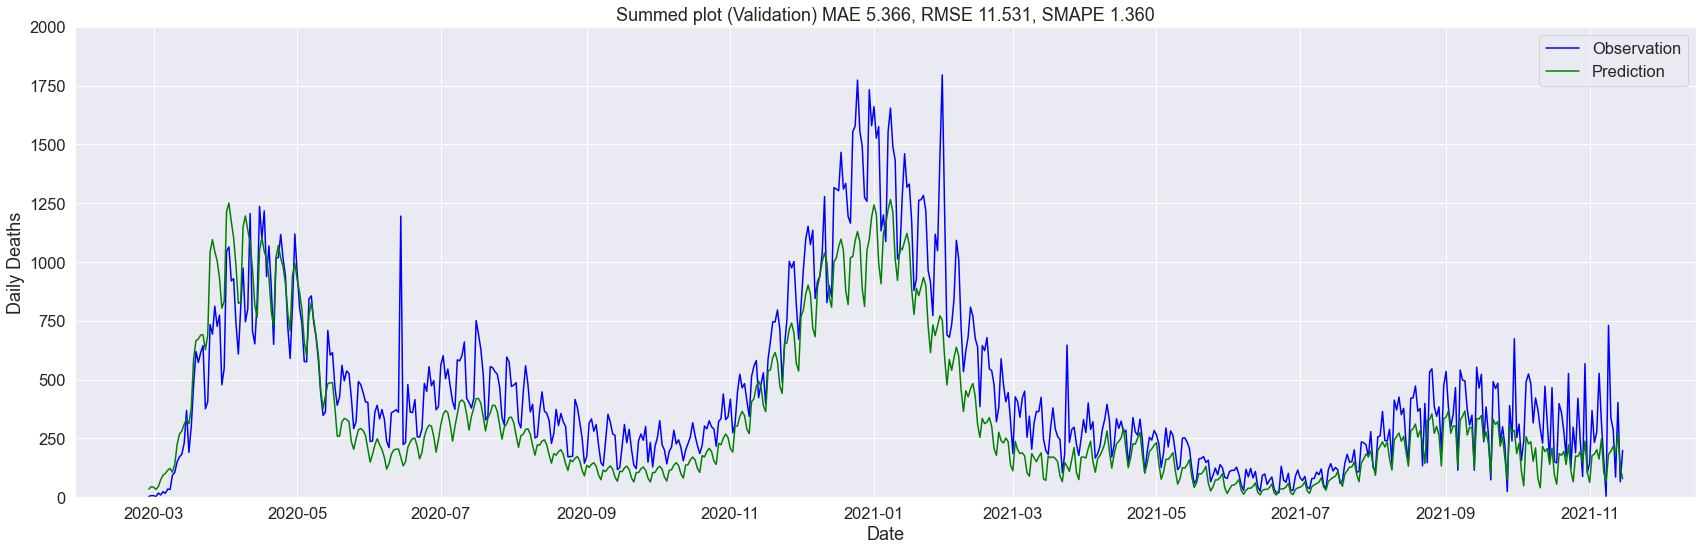

In [31]:
PlotC.makeSummedPlot(plot_titles, figure_names=figure_names)

In [35]:
import numpy as np

In [ ]:
parameterManager.train_start + np.timedelta()

In [27]:
parameterManager.train_start

Timestamp('2020-02-28 00:00:00')

In [30]:
import numpy as np

In [31]:
[parameterManager.train_start + np.timedelta64(days, 'D') for days in range(627)]

[Timestamp('2020-02-28 00:00:00'),
 Timestamp('2020-02-29 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-03-02 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-03-04 00:00:00'),
 Timestamp('2020-03-05 00:00:00'),
 Timestamp('2020-03-06 00:00:00'),
 Timestamp('2020-03-07 00:00:00'),
 Timestamp('2020-03-08 00:00:00'),
 Timestamp('2020-03-09 00:00:00'),
 Timestamp('2020-03-10 00:00:00'),
 Timestamp('2020-03-11 00:00:00'),
 Timestamp('2020-03-12 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-14 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-

In [38]:
targets.shape

(100, 627, 2)

In [28]:
np.sum(targets, axis=0).reshape(-1, len(parameterManager.target_column)).shape

NameError: name 'np' is not defined

In [ ]:
targets, predictions = sumCases(train_actuals, train_preds, number_of_locations)

resultPlotter = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - train', figsize=(24, 8))

In [44]:
df.groupby('Date').sum()['Cases']

Date
2020-02-28      12.520558
2020-02-29      23.607543
2020-03-01      20.806514
2020-03-02      36.546633
2020-03-03      36.619549
                 ...     
2022-05-13     917.466516
2022-05-14     319.774814
2022-05-15    1245.748510
2022-05-16       0.000000
2022-05-17       0.000000
Name: Cases, Length: 810, dtype: float64